In [1]:
import matplotlib.pyplot as plt
import numpy as np
import obspy
from obspy.core.trace import Trace, Stats
from obspy.core.stream import Stream
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

client = Client("IRIS")

def waveforms(start, end, adjtime):
    st = client.get_waveforms("XB", "ELYSE", "02", "B*", start-adjtime, end+adjtime, attach_response=True)
    st.detrend(type='simple')
    st_disp = st.copy()
    st_disp.remove_response(output='DISP')
    return st_disp

def uvw2enz(st):
    if len(st) != 3:
       print('Stream does not contain 3 Traces')
       return st
    for trace in st:
        head = trace.stats
        channel = head.channel
        if channel == 'BHU': U = trace.data
        elif channel == 'BHV': V = trace.data
        elif channel == 'BHW': W = trace.data
        else:
            print('Trace.channel is not BHU, BHV, or BHW')
            return st

    d = np.radians(-30)
    aU = np.radians(135)
    aV = np.radians(15)
    aW = np.radians(255)

    A = np.array([[np.cos(d)*np.sin(aU), np.cos(d)*np.cos(aU),-np.sin(d)],
                  [np.cos(d)*np.sin(aV), np.cos(d)*np.cos(aV), -np.sin(d)],
                  [np.cos(d)*np.sin(aW), np.cos(d)*np.cos(aW), -np.sin(d)]])

    B = np.linalg.inv(A)
    E,N,Z = np.dot(B,(U,V,W))

    head.channel = 'BHE'; trE = Trace(data=E, header=head)
    head.channel = 'BHN'; trN = Trace(data=N, header=head)
    head.channel = 'BHZ'; trZ = Trace(data=Z, header=head)
    stENZ = Stream(traces=[trE,trN,trZ])

    return stENZ

In [2]:
def rotate(c1,c2,a):
    """
    IN: c1,c2 (arrays) and a (angle)
    c1 c2 are the X and Y axes, respectively of a Cartesian coordinate system
    a is an angle in degrees, positive angle means a clockwise rotation of the coordinate system.
    OUT: o1, o2 (arrays)
    o1 o2 are the X and Y axes, respectively of a rotated Cartesian coordinate system
    """
    o1 = np.cos(np.radians(a))*c1 - np.sin(np.radians(a))*c2
    o2 = np.sin(np.radians(a))*c1 + np.cos(np.radians(a))*c2
    return o1, o2

In [6]:
%matplotlib notebook

<IPython.core.display.Javascript object>


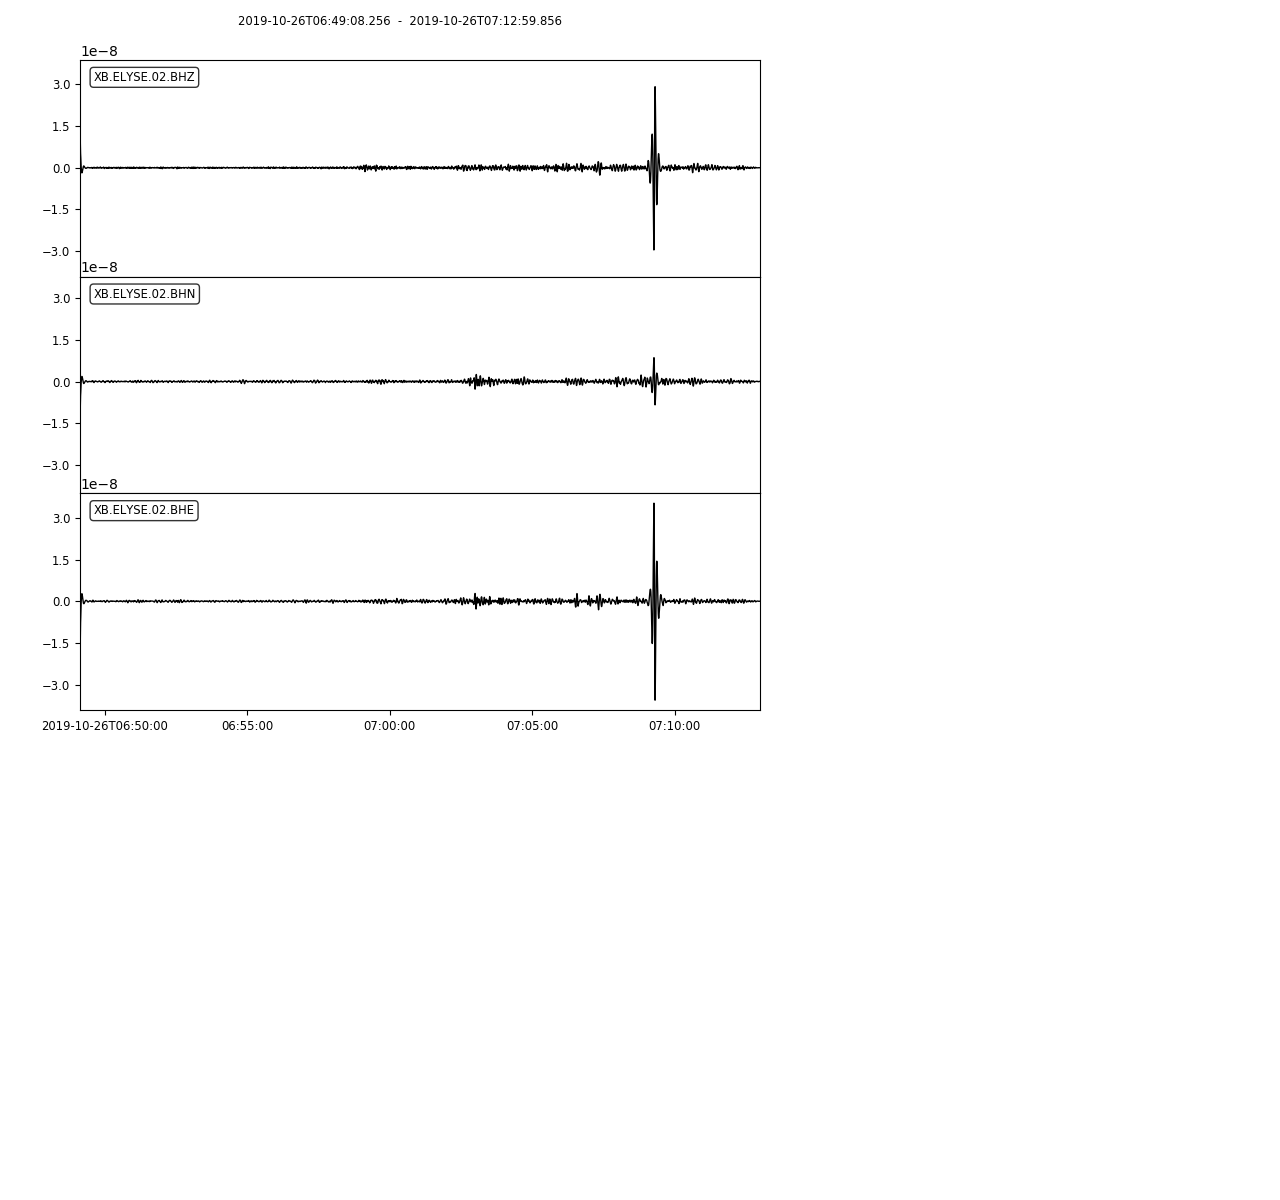

<IPython.core.display.Javascript object>


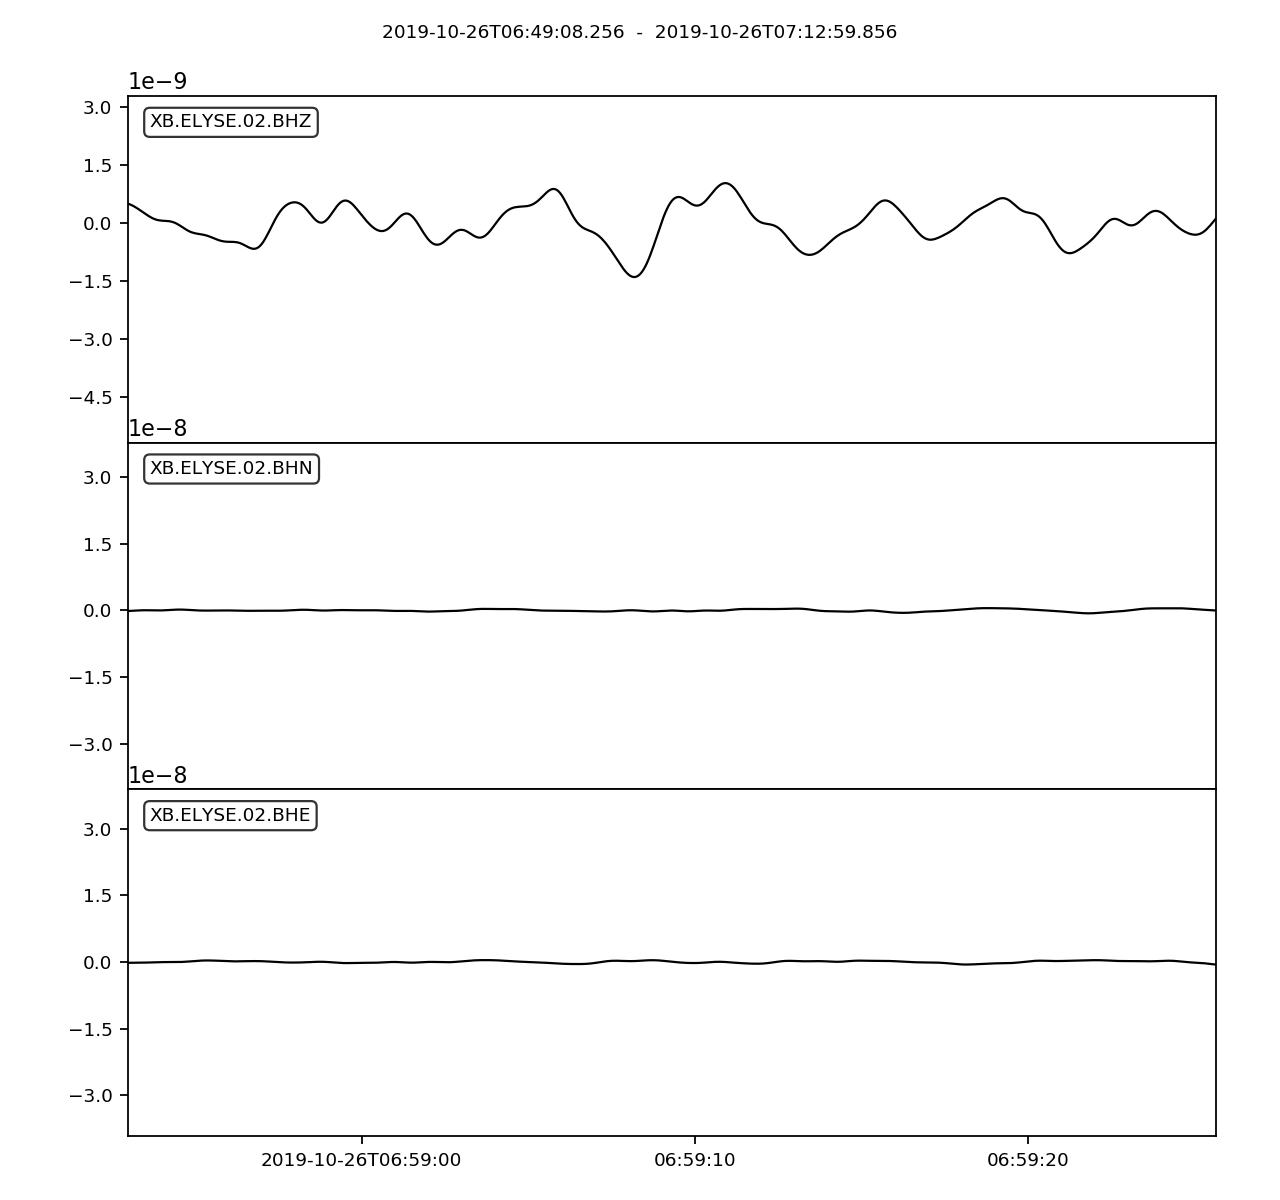

In [129]:
# #173a - 3sec interval
# begin = UTCDateTime('2019-05-23T02:22:59.48')  # p-wave arrival
# end = UTCDateTime('2019-05-23T02:25:53.50')    # s-wave arrival

# #173ab - 3sec interval
# begin = UTCDateTime('2019-05-23T02:23:03.30')  # p-wave arrival
# end = UTCDateTime('2019-05-23T02:25:56.37')    # s-wave arrival

# #235b - 3sec interval
# begin = UTCDateTime('2019-07-26T12:19:18')  # p-wave arrival
# end = UTCDateTime('2019-07-26T12:22:05')    # s-wave arrival

#325ab - 3sec interval
begin = UTCDateTime('2019-10-26T06:59:08.23')  # p-wave arrival
end = UTCDateTime('2019-10-26T07:02:59.9')    # s-wave arrival

st_uvw = waveforms(begin, end, 600)
st_z12 = uvw2enz(st_uvw)

stf = st_z12.copy()
stf.filter('bandpass', freqmin = 0.125, freqmax = 1.0, corners=4, zerophase=True)
stf.plot()

3 Trace(s) in Stream:
XB.ELYSE.02.BHE | 2019-10-26T06:59:07.706000Z - 2019-10-26T06:59:08.706000Z | 20.0 Hz, 21 samples
XB.ELYSE.02.BHN | 2019-10-26T06:59:07.706000Z - 2019-10-26T06:59:08.706000Z | 20.0 Hz, 21 samples
XB.ELYSE.02.BHZ | 2019-10-26T06:59:07.706000Z - 2019-10-26T06:59:08.706000Z | 20.0 Hz, 21 samples
3 Trace(s) in Stream:
XB.ELYSE.02.BHE | 2019-10-26T07:02:58.906000Z - 2019-10-26T07:03:14.906000Z | 20.0 Hz, 321 samples
XB.ELYSE.02.BHN | 2019-10-26T07:02:58.906000Z - 2019-10-26T07:03:14.906000Z | 20.0 Hz, 321 samples
XB.ELYSE.02.BHZ | 2019-10-26T07:02:58.906000Z - 2019-10-26T07:03:14.906000Z | 20.0 Hz, 321 samples


<IPython.core.display.Javascript object>


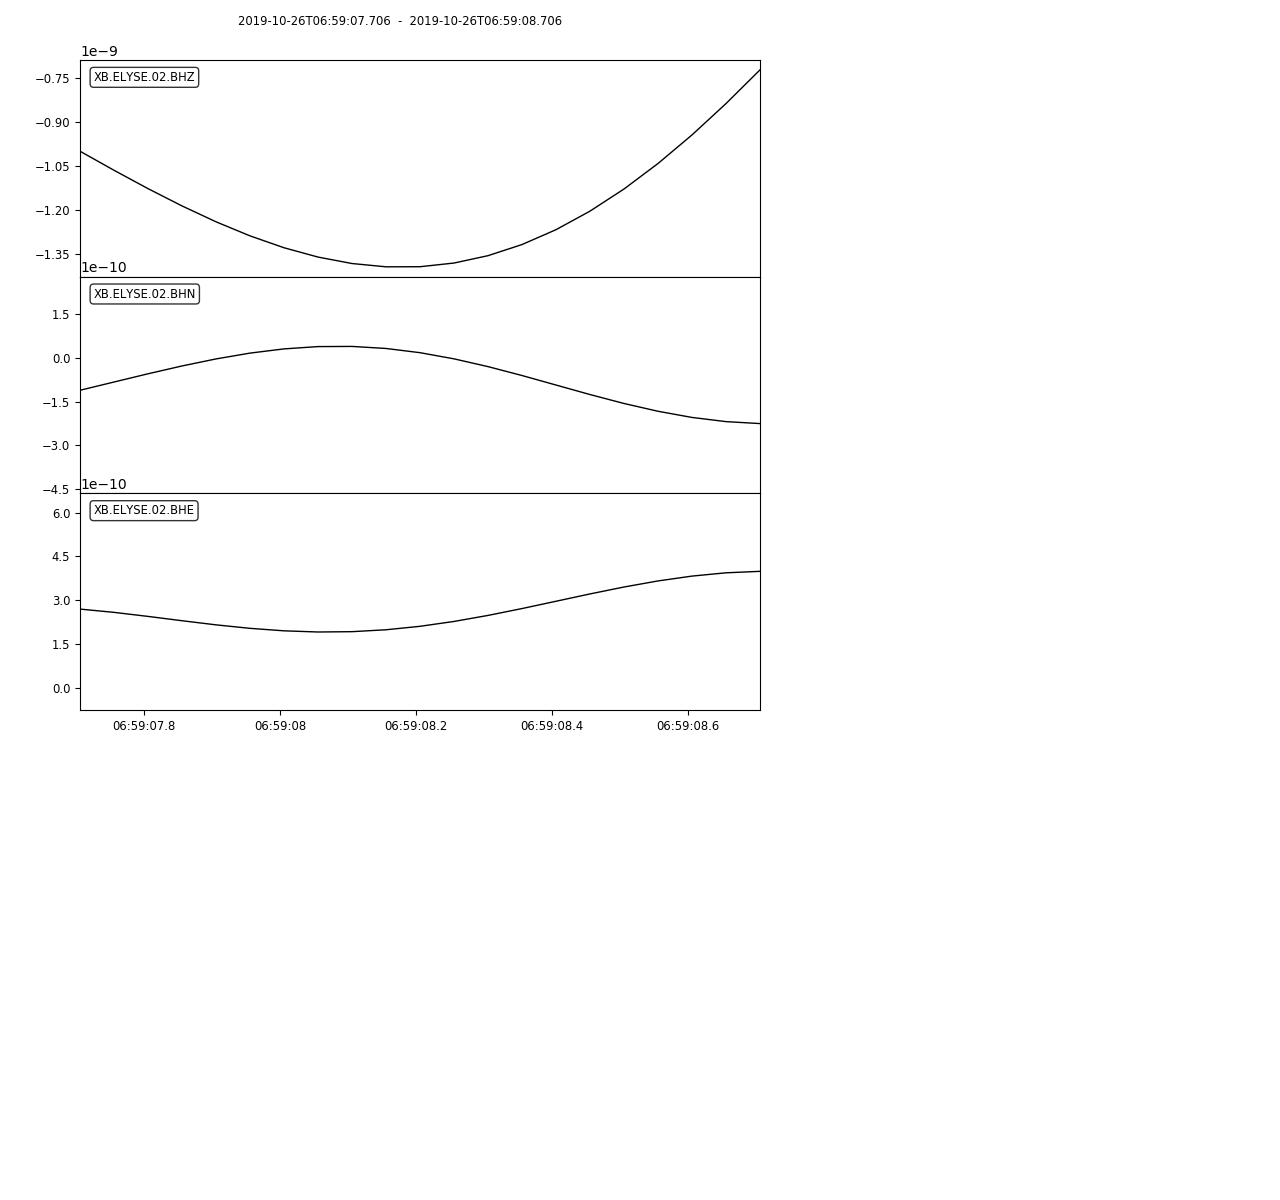

In [146]:
stP = stf.slice(starttime=begin-0.5,endtime=begin+0.5)
stS = stf.slice(starttime=end-1, endtime=end+15)
print(stP)
print(stS)
stP.plot();

In [147]:
scale = 1/200
hhe = scale * stP[0].data
hhn = scale * stP[1].data

tvall = []
alpha = np.arange(0,360,1)

# calculate Energy on channels oriented in the a direction, for all a in alpha:
# angle a is relative to orientation of channels 1 and 2.
# c1 is the x-axis, c2 is the y-axis
for a in alpha:
    hhT,hhR = rotate(hhe,hhn,a)
    Tenergy = np.dot(hhT,hhT)
    tvall.append(Tenergy)
    
tval = np.array(tvall) 
mina = alpha[np.argmin(tval)]

mina_guess = tval[np.where(alpha == mina)]
print(mina_guess)

#angle at which the energy is minimized
print('optimal angle = ',mina,' or ',mina-180)
thetat = str(mina); thetalt = str(mina-180)

[  2.22612203e-24]
optimal angle =  108  or  -72
